# Themenmodellierung von Nachrichtenmeldungen


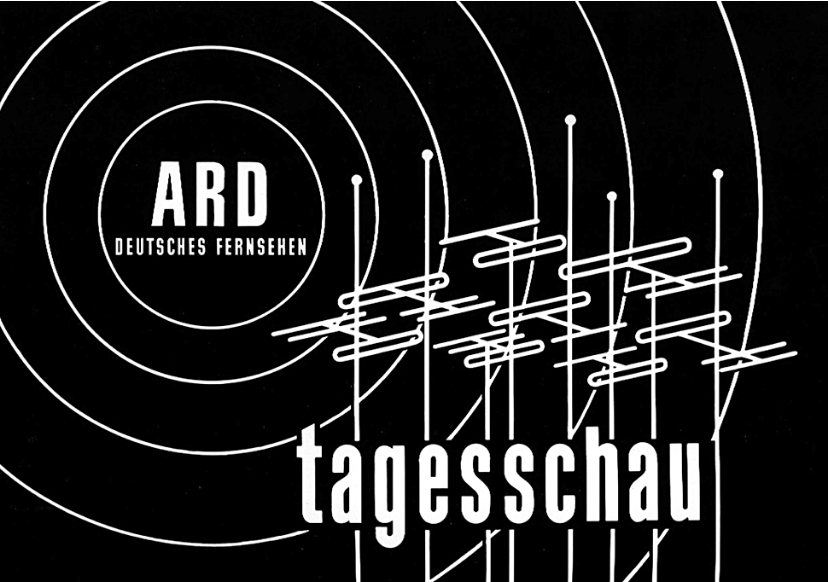

Ziel des Projektes ist es, Themen mittels NMF (Non-negative-Matrix Factorization) aus den Nachrichtenmeldungen der Tagesschau zu modellieren. Dafür werden die Daten aus dem YouTube Kanal der Tagesschau herangezogen welche über die offizielle YouTube-API zur Verfügung gestellt wurden. Der Zeitraum der Meldungen erstreckt sich vom 20.09.2021 bis zum 01.09.2023. In Betracht gezogen wird nur das Jahr 2023.

In [99]:
# Imports
import pandas as pd
import re
import matplotlib.pyplot as plt

In [33]:
# Dataset

df = pd.read_csv('youtube_aktuelle_meldungen_tagesschau.csv', index_col=0)
df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,8rDaJYj7LLc,tagesschau,ARD-DeutschlandTrend: Zuspruch für Ampel auf n...,Die Hälfte der Legislaturperiode ist fast erre...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T15:14:32Z,10884,224,NaN,NaN,PT5M51S,hd,False
1,cnDTnSvc9tY,tagesschau,Elektronikmesse IFA in Berlin gestartet,In Berlin ist am Freitag die Internationale Fu...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T13:46:24Z,1358,20,NaN,NaN,PT6M1S,hd,False
2,QurSQEExULc,tagesschau,Umweltbonus: E-Auto-Förderung nur noch für Pri...,Die staatliche Förderung für den Kauf eines El...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T13:33:29Z,1596,39,NaN,NaN,PT2M1S,hd,False
3,hdZsTXwGwwc,tagesschau,Partei in der Krise: Die Linke kämpft um Stabi...,Die Linke will bis Ende Oktober eine „tragfähi...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T12:14:02Z,1718,42,NaN,NaN,PT3M13S,hd,False
4,cTfBKyG8w3Q,tagesschau,Nach Großbrand in Südafrika: Lage von Obdachlo...,Bei einem verheerenden Feuer in einem fünfstöc...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T10:16:07Z,1993,28,NaN,NaN,PT3M5S,hd,False


In [34]:
# Add year only feature for better queries
df['year'] = df['publishedAt'].apply(lambda s: s.split('-')[0])

In [37]:
## Data Cleaning ##
# Remove links to newswebsite(s)
def remove_links(description):
    
    url_pattern = r'https?://\S+|www\.\S+'
    desc_wo_links = re.sub(url_pattern, '', description)
    
    return desc_wo_links

# Apply
df['description'] = df['description'].apply(remove_links)

In [38]:
# Split description from actual description and infotext referring to the newswebsite(s)
def split_description(description):
    
    description = description.split('\n\n')
    return description

# Apply
df['description'] = df['description'].apply(split_description)

In [39]:
# Filter info text out from description which refer to the newswebsite
def get_actual_description(description):
    
    patterns = [r'Weitere Informationen',
                r'Alle aktuellen Informationen und tagesschau24',
                r'Alle Sendungen, Livestreams, Dokumentation und Reportagen',
                r'Mehr Informationen zum Thema',
                r'Aktuelle Entwicklungen im Liveblog',
                r'Mehr zum Thema']
    
    idx = []
    for i in range(len(description)):
        for p in patterns:
            result = re.search(p, description[i])
            if result:
                idx.append(i)
                
    # if idx is empty
    if len(idx) == 0:
        
        # Get actual description
        actual_description = description[0:len(description)+1]
    else:
        actual_description = description[0:idx[0]]
                
    
    description = ' '.join(actual_description)
                
    return description

# Apply
df['description'] = df['description'].apply(get_actual_description)

In [40]:
# remove hashtags
# Some descriptions contain hashstags due to youtube-short videos in the playlist
def remove_hashtags(description):
    
    hashtag_pattern = r'#\w+'
    
    description = re.sub(hashtag_pattern, '', description)
    return description

# Apply
df['description'] = df['description'].apply(remove_hashtags)

In [41]:
# Remove newline chars
def remove_newline(description):
    
    description = re.sub('\n', '', description)
    return description

In [42]:
# Remove trailing whitespaces
df['description'] = df['description'].apply(lambda s: s.strip())

In [43]:
# Remove genderneutral words as the suffix 'innen' seperated by ':' will be considered as a single word
def de_gender(description):
    
    gender_pattern = r':innen'
    description = re.sub(gender_pattern, '', str(description))
    return description


# Remove punctuation
def remove_punctuation(description):
    
    punct_pattern = r'[^\w\s]'
    description = re.sub(punct_pattern, '', str(description))
    return description

# Apply
df['description'] = df['description'].apply(de_gender)
df['description'] = df['description'].apply(remove_punctuation)

In [44]:
'''TESTING TESTING TESTING'''
df.loc[0]['description']

'Die Hälfte der Legislaturperiode ist fast erreicht Wie blicken die Bürger im Moment auf den Zustand des Landes Laut dem ARDDeutschlandTrend eher verhalten Die wichtigsten Probleme sind aus Sicht der Bürger Wirtschaft und Migration Der Zuspruch für die Ampelkoalition erreicht im ARDDeutschlandTrend einen Tiefstand  die AfD ist weiter auf Höhenflug'

In [45]:
# Preprocessing
# Loading 
german_stopwords = pd.read_csv('german_stopwords.txt', header=None)[0].values.tolist()

In [56]:
# Only documents from 2023
df_23 = df[df['year'] == '2023']

In [59]:
df_23.loc[0]['description']

'Die Hälfte der Legislaturperiode ist fast erreicht Wie blicken die Bürger im Moment auf den Zustand des Landes Laut dem ARDDeutschlandTrend eher verhalten Die wichtigsten Probleme sind aus Sicht der Bürger Wirtschaft und Migration Der Zuspruch für die Ampelkoalition erreicht im ARDDeutschlandTrend einen Tiefstand  die AfD ist weiter auf Höhenflug'

In [47]:
# Vektorisierung
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=german_stopwords)
dtm = tfidf.fit_transform(df_23['description'])

C:\Users\LocalAdmin\anaconda3\envs\youtube-api\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bsp', 'zb'] not in stop_words.
  warnings.warn(


In [61]:
dtm

<1509x6921 sparse matrix of type '<class 'numpy.float64'>'
	with 45299 stored elements in Compressed Sparse Row format>

In [62]:
from sklearn.decomposition import NMF

In [131]:
# Modellierung
nmf = NMF(n_components=10, random_state=42)

In [132]:
nmf.fit(dtm)

C:\Users\LocalAdmin\anaconda3\envs\youtube-api\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=10, random_state=42)

In [133]:
# Top 15 Words per Topic found
for index,topic in enumerate(nmf.components_):
    print(f'Die TOP-15 Wörter zum Thema #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

Die TOP-15 Wörter zum Thema #0
['tagesthemen', 'geht', 'neue', 'mittendrin', 'rund', 'menschen', 'deutsche', 'deutschen', 'vergangenen', 'jahren', 'milliarden', 'millionen', 'euro', 'jahr', 'deutschland']


Die TOP-15 Wörter zum Thema #1
['scholz', 'angriffskrieg', 'treffen', 'russische', 'ukrainischen', 'kiew', 'unterstützung', 'putin', 'präsident', 'krieg', 'ukrainische', 'russland', 'selenskyj', 'russischen', 'ukraine']


Die TOP-15 Wörter zum Thema #2
['informationen', 'teilte', 'mann', 'stadt', 'leben', 'getötet', 'sei', 'mindestens', 'nacht', 'angaben', 'seien', 'polizei', 'verletzt', 'worden', 'menschen']


Die TOP-15 Wörter zum Thema #3
['jahren', 'prozentpunkte', 'jahr', 'mehrheit', 'ersten', 'inflation', 'partei', 'liegt', 'europäische', '20', 'leitzins', 'zentralbank', 'ezb', 'stimmen', 'prozent']


Die TOP-15 Wörter zum Thema #4
['begonnen', 'erste', 'nacht', 'eu', 'länder', 'gibt', 'treffen', 'baerbock', 'kritik', 'geht', 'ländern', 'china', 'heute', 'infos', 'thema']


Di

In [84]:
# Topic Labelling
topic_results = nmf.transform(dtm)

In [90]:
# Assign topic to label
import numpy as np
np.set_printoptions(precision=20)
topic_results[0]

array([0.000219803915190573 , 0.                   ,
       0.                   , 0.004176109770026011 ,
       0.001186371067338918 , 0.                   ,
       0.029001388534647767 , 0.                   ,
       0.                   , 0.0003595125759107698,
       0.0029647834692238324, 0.                   ,
       0.009865641367831402 , 0.009715438554805464 ,
       0.                   , 0.                   ,
       0.014773155121308477 , 0.009890304764764228 ,
       0.                   , 0.011827933728297758 ,
       0.                   , 0.                   ,
       0.                   , 0.003044963086799453 ,
       0.                   ])

In [86]:
topic_results[0].argmax()

6

In [89]:
# Creating topic labels
topic_results.argmax(axis=1)

array([ 6, 23, 16, ...,  1, 23, 19], dtype=int64)

In [88]:
df_23['Thema'] = topic_results.argmax(axis=1)

C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_12300\704000538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_23['Thema'] = topic_results.argmax(axis=1)


In [91]:
df_23.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,year,Thema
0,8rDaJYj7LLc,tagesschau,ARD-DeutschlandTrend: Zuspruch für Ampel auf n...,Die Hälfte der Legislaturperiode ist fast erre...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T15:14:32Z,10884,224,NaN,NaN,PT5M51S,hd,False,2023,6
1,cnDTnSvc9tY,tagesschau,Elektronikmesse IFA in Berlin gestartet,In Berlin ist am Freitag die Internationale Fu...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T13:46:24Z,1358,20,NaN,NaN,PT6M1S,hd,False,2023,23
2,QurSQEExULc,tagesschau,Umweltbonus: E-Auto-Förderung nur noch für Pri...,Die staatliche Förderung für den Kauf eines El...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T13:33:29Z,1596,39,NaN,NaN,PT2M1S,hd,False,2023,16
3,hdZsTXwGwwc,tagesschau,Partei in der Krise: Die Linke kämpft um Stabi...,Die Linke will bis Ende Oktober eine tragfähig...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T12:14:02Z,1718,42,NaN,NaN,PT3M13S,hd,False,2023,24
4,cTfBKyG8w3Q,tagesschau,Nach Großbrand in Südafrika: Lage von Obdachlo...,Bei einem verheerenden Feuer in einem fünfstöc...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T10:16:07Z,1993,28,NaN,NaN,PT3M5S,hd,False,2023,2


In [125]:
df_23[df_23['Thema'] == 23]

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,year,Thema
1,cnDTnSvc9tY,tagesschau,Elektronikmesse IFA in Berlin gestartet,In Berlin ist am Freitag die Internationale Fu...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-09-01T13:46:24Z,1358,20,NaN,NaN,PT6M1S,hd,False,2023,23
14,zuXS3EDsgJ8,tagesschau,Bildungsmonitor: Studie sieht deutliche Versch...,Das Bildungsniveau in Deutschland hat sich lau...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-08-30T12:57:51Z,14525,260,NaN,NaN,PT8M6S,hd,False,2023,23
25,HfuyFzHPysI,tagesschau,Haftstrafe für bereits verurteilte Jennifer W....,Die deutsche ISRückkehrerin Jennifer W ist in ...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-08-29T14:40:38Z,37981,684,NaN,NaN,PT6M1S,hd,False,2023,23
35,vWb2Yg_5ugM,tagesschau,Aktion in Loch Ness: Mit Sonar und Infrarot au...,Seit Jahrhunderten gibt es immer wieder Berich...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-08-28T13:25:36Z,13963,127,NaN,NaN,PT2M37S,hd,False,2023,23
37,HuLM2VLUwoU,tagesschau,Happy Birthday: Die Musikkassette wird 60 Jahr...,Zum ersten Mal bot sie die Möglichkeit unkompl...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-08-28T11:08:31Z,3814,144,NaN,NaN,PT2M4S,hd,False,2023,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,jg3ndPb4I9c,tagesschau,Neuer tagesschau-Podcast „11 KM“ will in die T...,11KM ist der neue StorytellingPodcast der tage...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-01-09T14:00:20Z,3349,77,NaN,NaN,PT2M2S,hd,False,2023,23
1473,sHs-CdRnqZ8,tagesschau,Neue Studie zum Klimawandel: Gletscher auf der...,Eisriesen werden sie genannt viele Gletscher ...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-01-06T16:00:32Z,17332,337,NaN,NaN,PT7M2S,hd,False,2023,23
1491,D0kgBAbpQaY,tagesschau,Ehemalige Skirennläuferin Rosi Mittermaier ges...,Die ehemalige deutsche Skirennläuferin und zwe...,"['rosi mittermaier', 'mittermaier', 'neureuthe...",2023-01-05T10:03:49Z,135851,1093,NaN,NaN,PT3M10S,hd,False,2023,23
1496,EX0IeZegGyE,tagesschau,US-Repräsentantenhaus: McCarthy bei Wahl wiede...,Nach mehreren Wahlgängen ohne Ergebnis hat das...,"['tagesschau', 'tagesthemen', 'ard', 'mdr', 'n...",2023-01-04T09:49:27Z,28654,590,NaN,NaN,PT9M2S,hd,False,2023,23


In [96]:
# Datavisualization

import seaborn as sns
sns.set_theme(style="whitegrid")

In [101]:
topics = [i for i in range(0,25)]

topic_count = []
for i in range(0,25):
    count = len(df_23[df_23['Thema'] == i])
    topic_count.append(count)
    
topic_count

[18,
 97,
 80,
 37,
 86,
 42,
 55,
 57,
 35,
 56,
 52,
 26,
 82,
 52,
 24,
 77,
 89,
 69,
 48,
 130,
 31,
 39,
 68,
 140,
 19]

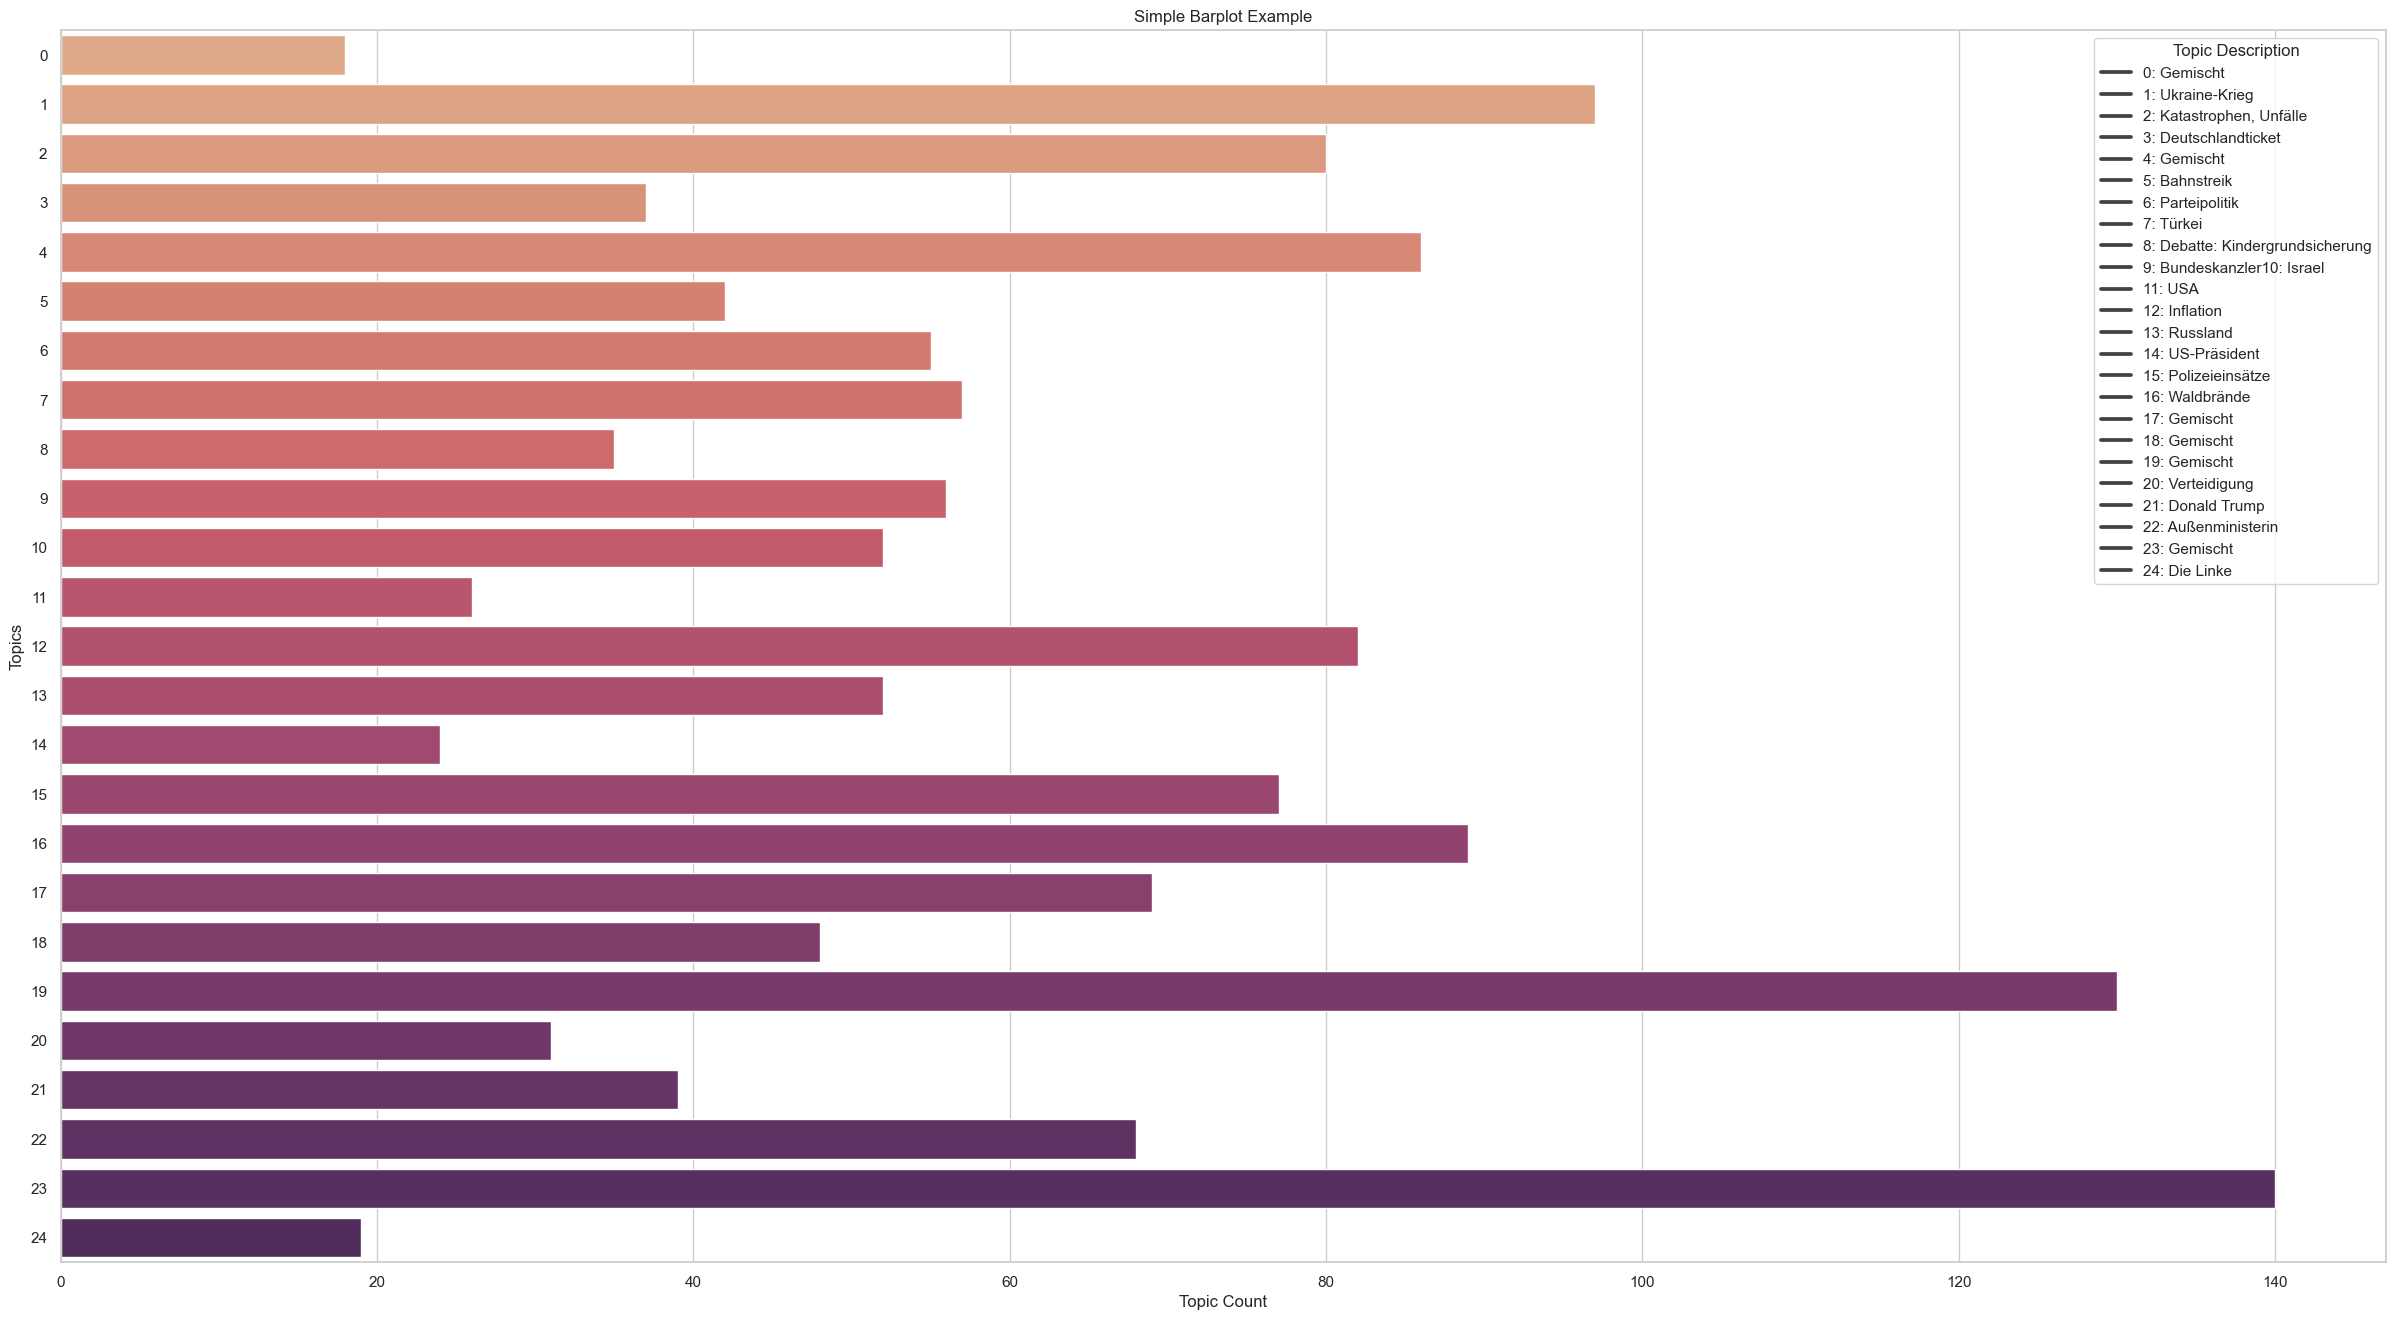

In [127]:
sns.set(style="whitegrid")  # Set the style of the plot (optional)
plt.figure(figsize=(30, 16))  # Set the figure size (optional)

sns.barplot(x=topic_count, y=topics, palette="flare", orient='h')

plt.xlabel("Topic Count")
plt.ylabel("Topics")
plt.title("Simple Barplot Example")

topic_id = [0, 1, 2, 3]

legend_labels = ['0: Gemischt', 
                 '1: Ukraine-Krieg', 
                 '2: Katastrophen, Unfälle', 
                 '3: Deutschlandticket',
                 '4: Gemischt',
                 '5: Bahnstreik',
                 '6: Parteipolitik',
                 '7: Türkei',
                 '8: Debatte: Kindergrundsicherung',
                 '9: Bundeskanzler'
                 '10: Israel',
                 '11: USA',
                 '12: Inflation',
                 '13: Russland',
                 '14: US-Präsident',
                 '15: Polizeieinsätze',
                 '16: Waldbrände',
                 '17: Gemischt',
                 '18: Gemischt',
                 '19: Gemischt',
                 '20: Verteidigung',
                 '21: Donald Trump',
                 '22: Außenministerin',
                 '23: Gemischt',
                 '24: Die Linke'
                ]
plt.legend(labels = legend_labels, title="Topic Description", loc='upper right')

# Show the plot
plt.show()

